## TUTORIAL 04 - Graetz problem 1
**_Keywords: successive constraints method_**

### 1. Introduction
This Tutorial addresses geometrical parametrization and the successive constraints method (SCM). In particular, we will solve the Graetz problem, which deals with forced heat convection in a channel $\Omega_o(\mu_0)$ divided into two parts $\Omega_o^1$ and $\Omega_o^2(\mu_0)$.

![mesh](data/mesh.png)

Boundaries $\Gamma_{o, 1} \cup \Gamma_{o, 5} \cup \Gamma_{o, 6}$ are kept at low temperature (say, zero), while boundaries $\Gamma_{o, 2}(\mu_0) \cup \Gamma_{o, 4}(\mu_0)$ are kept at high temperature (say, one). The convection is characterized by the velocity $\boldsymbol{\beta} = (x_1(1-x_1), 0)$, being $\boldsymbol{x}_o = (x_{o, 0}, x_1)$ the coordinate vector on the parametrized domain $\Omega_o(\mu_0)$.

The problem is characterized by two parameters. The first parameter $\mu_0$ controls the shape of deformable subdomain $\Omega_2(\mu_0)$. The heat transfer between the domains can be taken into account by means of the Péclet number, which will be labeled as the parameter $\mu_1$. The ranges of the two parameters are the following:
$$\mu_0 \in [0.1,10.0] \quad \text{and} \quad \mu_1 \in [0.01,10.0].$$

The parameter vector $\boldsymbol{\mu}$ is thus given by 
$$
\boldsymbol{\mu} = (\mu_0, \mu_1)
$$
on the parameter domain
$$
\mathbb{P}=[0.1,10.0]\times[0.01,10.0].
$$

In order to obtain a faster (yet, provably accurate) approximation of the problem, and avoiding _any_ remeshing, we pursue a model reduction by means of a certified reduced basis reduced order method from a fixed reference domain.
The successive constraints method will be used to evaluate the stability factors.

### 2. Parametrized formulation

Let $u_o(\boldsymbol{\mu})$ be the temperature in the domain $\Omega_o(\mu_0)$.

We will directly provide a weak formulation for this problem: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u_o(\boldsymbol{\mu})\in\mathbb{V}_o(\boldsymbol{\mu})$ such that

$$a_o\left(u_o(\boldsymbol{\mu}),v_o;\boldsymbol{\mu}\right)=f_o(v_o;\boldsymbol{\mu})\quad \forall v_o\in\mathbb{V}_o(\boldsymbol{\mu})$$

where

* the function space $\mathbb{V}_o(\boldsymbol{\mu})$ is defined as
$$
\mathbb{V}_o(\mu_0) = \left\{ v \in H^1(\Omega_o(\mu_0)): v|_{\Gamma_{o,1} \cup \Gamma_{o,5} \cup \Gamma_{o,6}} = 0, v|_{\Gamma_{o,2}(\mu_0) \cup \Gamma_{o,2}(\mu_0)} = 1 \right\}
$$
Note that, as in the previous tutorial, the function space is parameter dependent due to the shape variation. 
* the parametrized bilinear form $a_o(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V}_o(\boldsymbol{\mu}) \times \mathbb{V}_o(\boldsymbol{\mu}) \to \mathbb{R}$ is defined by
$$a_o(u_o,v_o;\boldsymbol{\mu}) = \mu_1\int_{\Omega_o(\mu_0)} \nabla u_o \cdot \nabla v_o \ d\boldsymbol{x} + \int_{\Omega_o(\mu_0)} x_1(1-x_1) \partial_{x} u_o\ v_o \ d\boldsymbol{x},$$
* the parametrized linear form $f_o(\cdot; \boldsymbol{\mu}): \mathbb{V}_o(\boldsymbol{\mu}) \to \mathbb{R}$ is defined by
$$f_o(v_o;\boldsymbol{\mu}) = 0.$$

The successive constraints method will be used to compute the stability factor of the bilinear form $a_o(\cdot, \cdot; \boldsymbol{\mu})$.

In [1]:
import os
import sys
sys.path.append('../../')

from mlnics import NN, Losses, Normalization, RONNData, IO, Training, ErrorAnalysis
from dolfin import *
from rbnics import *
import torch
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

## 3. Affine decomposition

In order to obtain an affine decomposition, we proceed as in the previous tutorial and recast the problem on a fixed, parameter _independent_, reference domain $\Omega$. As reference domain which choose the one characterized by $\mu_0 = 1$ which we generate through the generate_mesh notebook provided in the _data_ folder.
As in the previous tutorial, we pull back the problem to the reference domain $\Omega$.

In [2]:
@SCM()
@PullBackFormsToReferenceDomain()
@ShapeParametrization(
    ("x[0]", "x[1]"),  # subdomain 1
    ("mu[0]*(x[0] - 1) + 1", "x[1]"),  # subdomain 2
)
class Graetz(EllipticCoerciveProblem):

    # Default initialization of members
    @generate_function_space_for_stability_factor
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        EllipticCoerciveProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.u = TrialFunction(V)
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=subdomains)
        self.ds = Measure("ds")(subdomain_data=boundaries)
        # Store the velocity expression
        self.vel = Expression("x[1]*(1-x[1])", element=self.V.ufl_element())
        # Customize eigen solver parameters
        self._eigen_solver_parameters.update({
            "bounding_box_minimum": {
                "problem_type": "gen_hermitian", "spectral_transform": "shift-and-invert",
                "spectral_shift": 1.e-5, "linear_solver": "mumps"
            },
            "bounding_box_maximum": {
                "problem_type": "gen_hermitian", "spectral_transform": "shift-and-invert",
                "spectral_shift": 1.e5, "linear_solver": "mumps"
            },
            "stability_factor": {
                "problem_type": "gen_hermitian", "spectral_transform": "shift-and-invert",
                "spectral_shift": 1.e-5, "linear_solver": "mumps"
            }
        })

    # Return custom problem name
    def name(self):
        return "Graetz1"

    # Return theta multiplicative terms of the affine expansion of the problem.
    @compute_theta_for_stability_factor
    def compute_theta(self, term):
        mu = self.mu
        if term == "a":
            theta_a0 = mu[1]
            theta_a1 = 1.0
            return (theta_a0, theta_a1)
        elif term == "f":
            theta_f0 = 1.0
            return (theta_f0,)
        elif term == "dirichlet_bc":
            theta_bc0 = 1.0
            return (theta_bc0,)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    @assemble_operator_for_stability_factor
    def assemble_operator(self, term):
        v = self.v
        dx = self.dx
        if term == "a":
            u = self.u
            vel = self.vel
            a0 = inner(grad(u), grad(v)) * dx
            a1 = vel * u.dx(0) * v * dx
            return (a0, a1)
        elif term == "f":
            f0 = Constant(0.0) * v * dx
            return (f0,)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.V, Constant(0.0), self.boundaries, 1),
                   DirichletBC(self.V, Constant(1.0), self.boundaries, 2),
                   DirichletBC(self.V, Constant(1.0), self.boundaries, 4),
                   DirichletBC(self.V, Constant(0.0), self.boundaries, 5),
                   DirichletBC(self.V, Constant(0.0), self.boundaries, 6)]
            return (bc0,)
        elif term == "inner_product":
            u = self.u
            x0 = inner(grad(u), grad(v)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")

## 4. Main program
### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh_1.ipynb](data/generate_mesh_1.ipynb) notebook.

In [3]:
mesh = Mesh("data/graetz_1.xml")
subdomains = MeshFunction("size_t", mesh, "data/graetz_physical_region_1.xml")
boundaries = MeshFunction("size_t", mesh, "data/graetz_facet_region_1.xml")

### 4.2. Create Finite Element space (Lagrange P1)

In [4]:
V = FunctionSpace(mesh, "Lagrange", 1)

### 4.3. Allocate an object of the Graetz class

In [5]:
problem = Graetz(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [(0.1, 10.0), (0.01, 10.0)]
problem.set_mu_range(mu_range)

### 4.4. Prepare reduction with a reduced basis method

In [6]:
reduction_method = ReducedBasis(problem)
reduction_method.set_Nmax(30, SCM=20)
reduction_method.set_tolerance(1e-5, SCM=1e-3)

### 4.5. Perform the offline phase

#### 4.5.1 Fit Reduction Method

In [7]:
lifting_mu = (1.0, 1.0)
problem.set_mu(lifting_mu)
reduction_method.initialize_training_set(200, SCM=250)
reduced_problem = reduction_method.offline()

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
=                           SCM offline phase begins                           =

bounding_box_min[0] = 4.573977915173222e-20
bounding_box_max[0] = 2.0
bounding_box_min[1] = 1.8634724839594607e-20
bounding_box_max[1] = 1.989768296436523
bounding_box_min[2] = 6.776263578034403e-21
bounding_box_max[2] = 1.985968279754161
bounding_box_min[3]


find initial mu
initial maximum absolute error estimator over training set = 33.460375177033086
initial maximum relative error estimator over training set = 1.0

#################################### N = 0 #####################################
truth solve for mu = (9.904355579227373, 2.1768008741407545)
update basis matrix
build reduced operators
reduced order solve
build operators for error estimation
absolute error for current mu = 7.045748478262153e-15
absolute error estimator for current mu = 8.871545829810862e-07
find next mu
maximum absolute error estimator over training set = 7.856529717300387
maximum relative error estimator over training set = 0.2348010049419004

#################################### N = 1 #####################################
truth solve for mu = (0.21596943343151953, 3.6061808641388553)
update basis matrix
build reduced operators
reduced order solve
build operators for error estimation
absolute error for current mu = 5.066144402570152e-15
absolute error estim

reduced order solve
build operators for error estimation
absolute error for current mu = 9.597167329435653e-14
absolute error estimator for current mu = 7.405568157799734e-09
find next mu
maximum absolute error estimator over training set = 0.0027382942098524627
maximum relative error estimator over training set = 8.183692488098592e-05

#################################### N = 16 ####################################
truth solve for mu = (9.074899442289672, 7.742732853659401)
update basis matrix
build reduced operators
reduced order solve
build operators for error estimation
absolute error for current mu = 8.700663270668119e-13
absolute error estimator for current mu = 6.988403139045371e-07
find next mu
maximum absolute error estimator over training set = 0.001496315717719763
maximum relative error estimator over training set = 4.471903586863608e-05

#################################### N = 17 ####################################
truth solve for mu = (3.398137005083555, 0.82020288598008

#### 4.5.2 Train PINN

Given a training set $\Xi_{PINN} = (\boldsymbol{\mu}^{(1)}, \dots, \boldsymbol{\mu}^{(N_\text{PINN})})$ of parameters for the PDE, we train a Physics-Informed Neural Network (PINN) $u^{NN}(\boldsymbol{\mu})$ for the reduced order equations dependent on the weights and biases $W$ of the network to minimize the loss function

$$L_{PINN}(\Xi_{PINN}; W) = \frac{1}{N_\text{PINN}} \sum_{i=1}^{N_\text{PINN}} \|A(\boldsymbol{\mu^{(i)}}) u^{NN}(\boldsymbol{\mu}^{(i)}; W) - \boldsymbol{f}(\boldsymbol{\mu}^{(i)})\|_2^2 + \left|u^{NN}(\boldsymbol{\mu}^{(i)})_1 - 1\right|^{\,2}$$

over $W$, where for a given $\boldsymbol{\mu}$, $A(\boldsymbol{\mu})$ is the assembled reduced matrix corresponding to the bilinear form $a$ and $\boldsymbol{f}(\boldsymbol{\mu})$ is the assembled reduced vector corresponding to the linear form $f$.

The second term in the sum enforces boundary conditions by training the first basis function coefficient to be one, as our first basis function contains the boundary condition while all other basis functions are zero on the boundary.

In [8]:
input_normalization_pinn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_pinn = Normalization.StandardNormalization()

pinn_net  = NN.RONN("PINN", problem, reduction_method, n_hidden=2, n_neurons=20)
pinn_loss = Losses.PINN_Loss(pinn_net, output_normalization_pinn)
data      = RONNData.RONNDataLoader(pinn_net, validation_proportion=0.2, 
                                    num_without_snapshots=10)
optimizer = torch.optim.Adam(pinn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

pinn_trainer = Training.PINNTrainer(
    pinn_net, data, pinn_loss, optimizer, scheduler,
    input_normalization_pinn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    pinn_net, data, pinn_trainer, optimizer
)

In [9]:
pinn_trainer.train()

Operator 's' not implemented. Continuing without operator 's'...
Operator 'stability_factor_left_hand_matrix' not implemented. Continuing without operator 'stability_factor_left_hand_matrix'...
Operator 'stability_factor_right_hand_matrix' not implemented. Continuing without operator 'stability_factor_right_hand_matrix'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 'stability_factor_left_hand_matrix' not implemented. Continuing without operator 'stability_factor_left_hand_matrix'...
Operator 'stability_factor_right_hand_matrix' not implemented. Continuing without operator 'stability_factor_right_hand_matrix'...
0 	Loss(training) = 2865.544741107401 	Loss(validation) = 727.0425839233682
100 	Loss(training) = 54.17322781284817 	Loss(validation) = 46.429994278123296
200 	Loss(training) = 13.272054346918187 	Loss(validation) = 5.158970928749229
300 	Loss(training) = 7.177679867859182 	Loss(validation) = 3.511110846198373
400 	Loss(training) = 4.77732623578648

9400 	Loss(training) = 0.9125849249989747 	Loss(validation) = 0.9152244955356782
9500 	Loss(training) = 0.9120346825363965 	Loss(validation) = 0.9150202505883315
9600 	Loss(training) = 0.9241379481569627 	Loss(validation) = 0.9170253048083296
9700 	Loss(training) = 0.9110662431283257 	Loss(validation) = 0.9145415495925715
9800 	Loss(training) = 0.9105844637843199 	Loss(validation) = 0.914260339772336
9900 	Loss(training) = 0.9101424579222626 	Loss(validation) = 0.9139749165322107


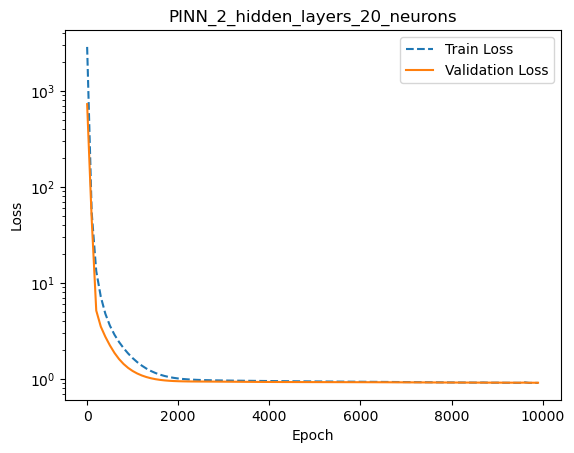

In [10]:
fig, ax = Training.plot_loss(pinn_trainer, pinn_net)

#### 4.5.3 Train PDNN

Given a training set $\Xi_{PDNN} = ((\boldsymbol{\mu}^{(1)}, u^{\text{HF}}(\boldsymbol{\mu}^{(1)})), \dots, (\boldsymbol{\mu}^{(N_\text{PDNN})}, u^{\text{HF}}(\boldsymbol{\mu}^{(N_\text{PDNN})})))$ of parameter and high fidelity solution pairs for the PDE, we train a Projection-Driven Neural Network (PDNN) $\operatorname{N}_W(\boldsymbol{\mu})$ dependent on the weights and biases $W$ of the network to minimize the loss function
$$L_{PDNN}(\Xi_{PDNN}; W) = \frac{1}{N_\text{PDNN}} \sum_{i=1}^{N_\text{PDNN}} \|u^{NN}(\boldsymbol{\mu}^{(i)}; W) - U^T u^{\text{HF}}(\boldsymbol{\mu}^{(i)})\|_2^2,$$
where for a given $\boldsymbol{\mu}$, the quantity $U^T u^{\text{HF}}(\boldsymbol{\mu})$ is the projection of the high fidelity solution $u^{\text{HF}}(\boldsymbol{\mu})$ onto the reduced order space.

In [11]:
input_normalization_pdnn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_pdnn = Normalization.StandardNormalization()

pdnn_net  = NN.RONN("PDNN", problem, reduction_method, n_hidden=2, n_neurons=40)
pdnn_loss = Losses.PDNN_Loss(pdnn_net, output_normalization_pdnn)
data      = RONNData.RONNDataLoader(pdnn_net, validation_proportion=0.2)
optimizer = torch.optim.Adam(pdnn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

pdnn_trainer = Training.PDNNTrainer(
    pdnn_net, data, pdnn_loss, optimizer, scheduler,
    input_normalization_pdnn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    pdnn_net, data, pdnn_trainer, optimizer
)

In [12]:
pdnn_trainer.train()

0 	Loss(training) = 1.0862826614032297 	Loss(validation) = 0.3232858664538502
100 	Loss(training) = 0.770463334751451 	Loss(validation) = 0.33502580801391013
200 	Loss(training) = 0.4655814632571516 	Loss(validation) = 0.45691013408758896
300 	Loss(training) = 0.3355588785662252 	Loss(validation) = 0.38473092131640385
400 	Loss(training) = 0.23740819459554438 	Loss(validation) = 0.40101428102991044
500 	Loss(training) = 0.17001015439797404 	Loss(validation) = 0.43715011055207237
600 	Loss(training) = 0.11977864061180375 	Loss(validation) = 0.49227090143140084
700 	Loss(training) = 0.08441135059051091 	Loss(validation) = 0.5437542502484439
800 	Loss(training) = 0.060544920287831434 	Loss(validation) = 0.5915958955277643
900 	Loss(training) = 0.04023441851151717 	Loss(validation) = 0.6241507790880051
1000 	Loss(training) = 0.025056019074858826 	Loss(validation) = 0.6408108460437496
1100 	Loss(training) = 0.015888554515631266 	Loss(validation) = 0.644341699015734
1200 	Loss(training) = 0.

9800 	Loss(training) = 8.438087925325034e-08 	Loss(validation) = 0.6315934600689851
9900 	Loss(training) = 1.6938890032079341e-06 	Loss(validation) = 0.6320837881756517


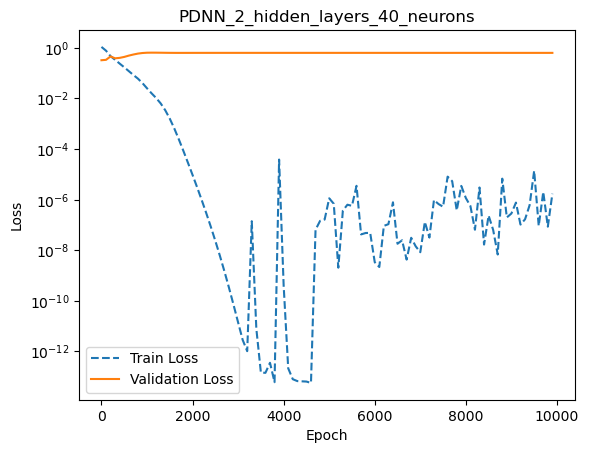

In [13]:
fig, ax = Training.plot_loss(pdnn_trainer, pdnn_net)

#### 4.5.4 Train PRNN

We train a Physics-Reinforced Neural Network (PRNN) $N_W(\boldsymbol{\mu})$ dependent on the weights and biases $W$ of the network to minimize the loss function

$$L_{PRNN}(\Xi_{PINN}, \Xi_{PDNN}; W) = L_{PINN}(\Xi_{PINN}; W) + \omega L_{PDNN}(\Xi_{PDNN}; W)$$

where $\omega$ is a scaling parameter which can be chosen freely.

In [14]:
input_normalization_prnn = Normalization.IdentityNormalization(input_normalization=True)
output_normalization_prnn = Normalization.IdentityNormalization()

omega = 100.
prnn_net  = NN.RONN(f"PRNN_{omega}", problem, reduction_method, n_hidden=2, n_neurons=40)
prnn_loss = Losses.PRNN_Loss(prnn_net, output_normalization_prnn, omega=omega)
data      = RONNData.RONNDataLoader(prnn_net, validation_proportion=0.2,
                                    num_without_snapshots=100)
optimizer = torch.optim.Adam(prnn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

prnn_trainer = Training.PRNNTrainer(
    prnn_net, data, prnn_loss, optimizer, scheduler,
    input_normalization_prnn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    prnn_net, data, prnn_trainer, optimizer
)

In [15]:
prnn_trainer.train()

Operator 's' not implemented. Continuing without operator 's'...
Operator 'stability_factor_left_hand_matrix' not implemented. Continuing without operator 'stability_factor_left_hand_matrix'...
Operator 'stability_factor_right_hand_matrix' not implemented. Continuing without operator 'stability_factor_right_hand_matrix'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 'stability_factor_left_hand_matrix' not implemented. Continuing without operator 'stability_factor_left_hand_matrix'...
Operator 'stability_factor_right_hand_matrix' not implemented. Continuing without operator 'stability_factor_right_hand_matrix'...
0 	Loss(training) = 636.9150537465816 	Loss(validation) = 334.2613184769541
100 	Loss(training) = 14.289195547854085 	Loss(validation) = 18.38742712319472
200 	Loss(training) = 10.40981605001176 	Loss(validation) = 13.552500012779797
300 	Loss(training) = 8.762350613162068 	Loss(validation) = 11.133925217116994
400 	Loss(training) = 7.9972150246116

9600 	Loss(training) = 4.307614438661346 	Loss(validation) = 9.047383954209659
9700 	Loss(training) = 4.298405631854206 	Loss(validation) = 9.037983892710873
9800 	Loss(training) = 4.303624784799236 	Loss(validation) = 9.005170184133295
9900 	Loss(training) = 4.273355162299151 	Loss(validation) = 8.998671475133154


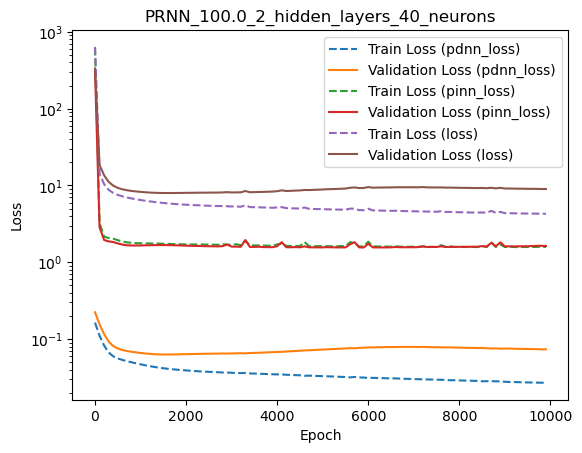

In [16]:
fig, ax = Training.plot_loss(prnn_trainer, prnn_net, separate=True)

### 4.6. Perform an error analysis

#### 4.6.1 Reduction Method Error Analysis

In [18]:
np.random.seed(0)

reduction_method.initialize_testing_set(100, SCM=100)
test_set_mu = torch.tensor(reduction_method.testing_set)
online_mu = tuple(np.array(reduction_method.testing_set)[0,:])

#### 4.6.2 PINN Error Analysis

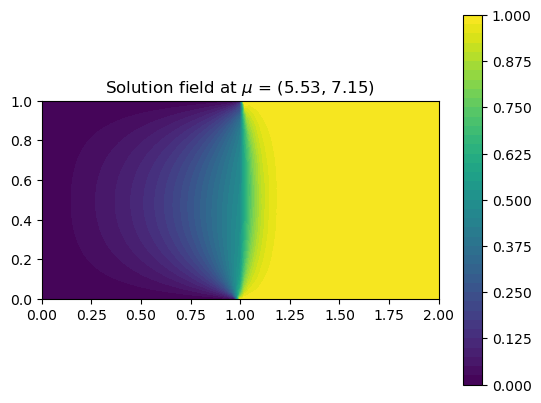

In [19]:
ErrorAnalysis.plot_solution(
    pinn_net, online_mu, input_normalization_pinn, output_normalization_pinn
)

In [20]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pinn_net, test_set_mu, input_normalization_pinn, output_normalization_pinn
)

################################# PINN N = 22 ##################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.6599282878923246	0.6599282870810688	6.496969828135308e-07
mean	0.9448451056490208	0.9448451041219954	1.2133997923443015e-05
max	1.0494426078977552	1.0494426090337639	9.265282030776046e-05


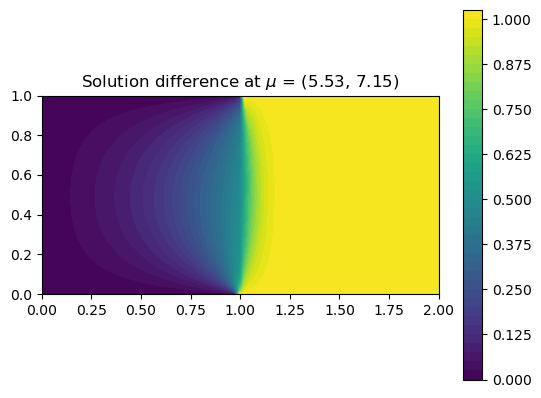

In [21]:
ErrorAnalysis.plot_solution_difference(
    pinn_net, online_mu, input_normalization_pinn, output_normalization_pinn
)

#### 4.6.3 PDNN Error Analysis

In [22]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pdnn_net, test_set_mu, input_normalization_pdnn, output_normalization_pdnn
)

################################# PDNN N = 22 ##################################
ERROR	NN-HF			NN-RO			RO-HF
min	8.083059212643341e-05	8.082882494845747e-05	6.496969828135308e-07
mean	0.1263073585012371	0.12630746723133593	1.2133997923443015e-05
max	0.48560939914910756	0.48560975535900536	9.265282030776046e-05


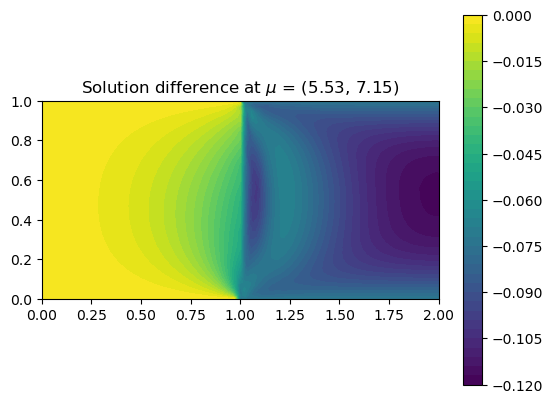

In [23]:
ErrorAnalysis.plot_solution_difference(
    pdnn_net, online_mu, input_normalization_pdnn, output_normalization_pdnn
)

#### 4.6.4 PRNN Error Analysis

In [24]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    prnn_net, test_set_mu, input_normalization_prnn, output_normalization_prnn
)

############################## PRNN_100.0 N = 22 ###############################
ERROR	NN-HF			NN-RO			RO-HF
min	0.025921854522574603	0.02592101589165375	6.496969828135308e-07
mean	0.8300909454702409	0.8300909347982715	1.2133997923443015e-05
max	1.195617309062094	1.195617326904739	9.265282030776046e-05


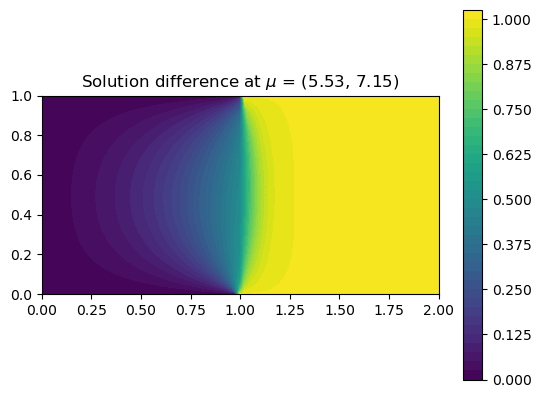

In [25]:
ErrorAnalysis.plot_solution_difference(
    prnn_net, online_mu, input_normalization_prnn, output_normalization_prnn
)

#### 4.6.5 Neural Network Error Comparison

In [27]:
nets = dict()
nets["pinn_net"] = pinn_net
nets["pdnn_net"] = pdnn_net
nets["prnn_net"] = prnn_net

input_normalizations = dict()
input_normalizations["pinn_net"] = input_normalization_pinn
input_normalizations["pdnn_net"] = input_normalization_pdnn
input_normalizations["prnn_net"] = input_normalization_prnn

output_normalizations = dict()
output_normalizations["pinn_net"] = output_normalization_pinn
output_normalizations["pdnn_net"] = output_normalization_pdnn
output_normalizations["prnn_net"] = output_normalization_prnn

_ = ErrorAnalysis.error_analysis_by_network(
    nets, test_set_mu, input_normalizations, output_normalizations, euclidean=False
)

#####################################################################################
Mean Relative Error for N = 22 Basis Functions
Network		NN-HF			NN-RO			RO-HF
pinn_net	0.9448451056490208	0.9448451041219954	1.2133997923443015e-05
pdnn_net	0.1263073585012371	0.12630746723133593	1.2133997923443015e-05
prnn_net	0.8300909454702409	0.8300909347982715	1.2133997923443015e-05
#####################################################################################


### 4.8. Perform a speedup analysis

In [ ]:
reduction_method.initialize_testing_set(100, SCM=100)
reduction_method.error_analysis()
reduction_method.speedup_analysis()

=                          SCM error analysis begins                           =

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SCM 0 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SCM 1 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SCM 2 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SCM 3 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SCM 4 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SCM 5 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SCM 6 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SCM 7 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SCM 8 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SCM 9 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SCM 10 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~